In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [3]:
Y_START, Y_END = 25, 35
X_START, X_END = 0, 1315

In [4]:
def imread_gs(path: str) -> np.ndarray:
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def crop(img: np.ndarray,
         x_params: tuple[int, int] = (X_START, X_END),
         y_params: tuple[int, int] = (Y_START, Y_END)
        ) -> np.ndarray:
    return img[y_params[0]:y_params[1], x_params[0]:x_params[1]]


def show(img: np.ndarray) -> None:
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')

In [5]:
pmma_img = imread_gs('data/pmma_192648.tif')
benzo_img = imread_gs('data/benzoic1000msgain_193519.tif')

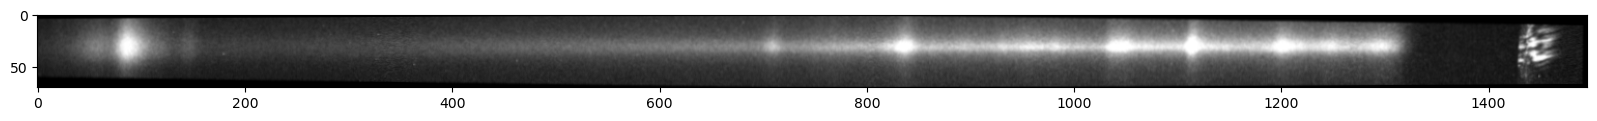

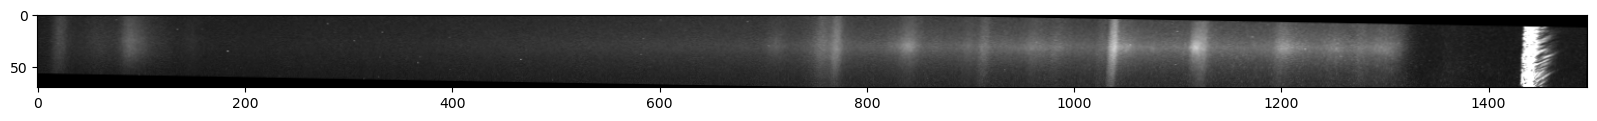

In [6]:
show(pmma_img)
show(benzo_img)

In [7]:
pmma_img.shape

(70, 1496)

In [8]:
benzo_img.shape

(70, 1496)

In [9]:
pmma_cropped = crop(pmma_img)
benzo_cropped = crop(benzo_img)

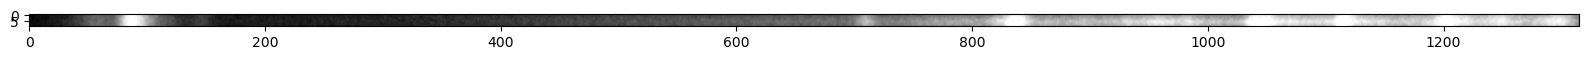

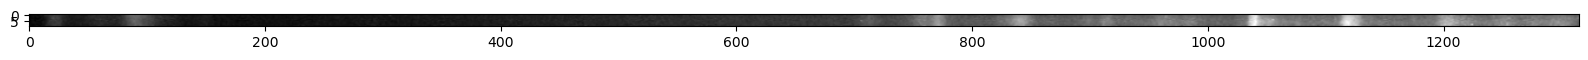

In [10]:
show(pmma_cropped)
show(benzo_cropped)

In [11]:
pmma_spec = pmma_cropped.sum(axis=0, dtype=np.int64)
benzo_spec = benzo_cropped.sum(axis=0, dtype=np.int64)

# trying to process in wavelength space

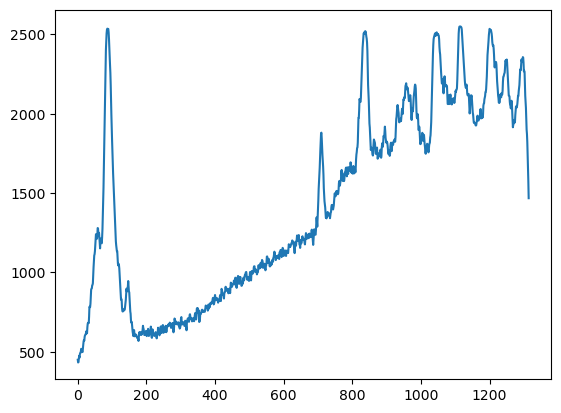

In [12]:
plt.plot(pmma_spec)

[  88  145  710  836  895  958  981 1045 1115 1203 1247 1295]


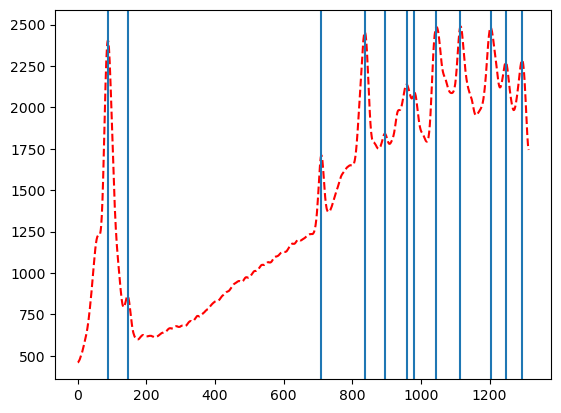

In [13]:
pmma_smoothed = gaussian_filter(pmma_spec, 5)
pmma_peaks = find_peaks(pmma_smoothed, prominence=15)[0]
print(pmma_peaks)

plt.plot(pmma_smoothed, 'r--')
for x in pmma_peaks:
    plt.axvline(x)

[  22   91  148  713  769  840  914  963 1040 1120 1204 1252 1297]


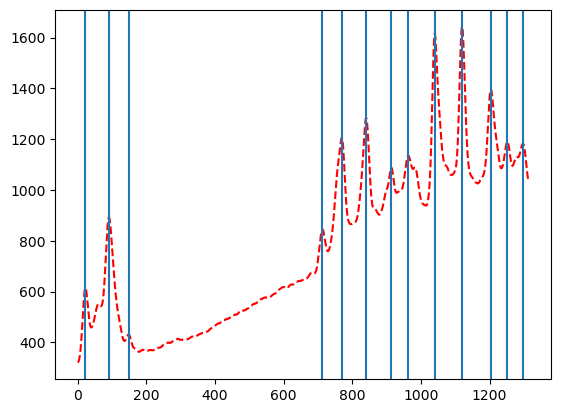

In [14]:
benzo_smoothed = gaussian_filter(benzo_spec, 5)
benzo_peaks = find_peaks(benzo_smoothed, prominence=15)[0]
print(benzo_peaks)

plt.plot(benzo_smoothed, 'r--')
for x in benzo_peaks:
    plt.axvline(x)

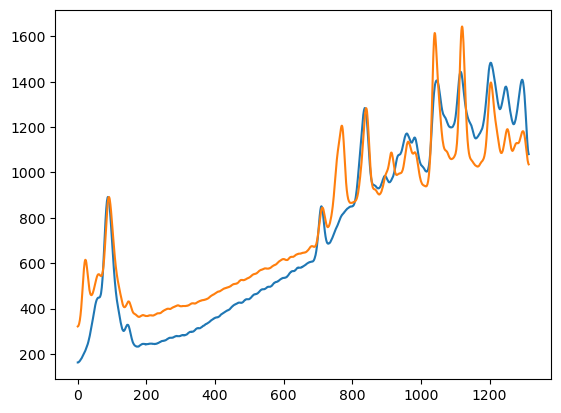

In [15]:
alpha = (benzo_smoothed[91]/pmma_smoothed[88] - benzo_smoothed[840]/pmma_smoothed[836])/(88-836)
beta = benzo_smoothed[91]/pmma_smoothed[88] - alpha * 88

ps_n = np.empty_like(pmma_smoothed)
for x, y in enumerate(pmma_smoothed):
    ps_n[x] = (alpha * x + beta) * y

plt.plot(ps_n)
plt.plot(benzo_smoothed)

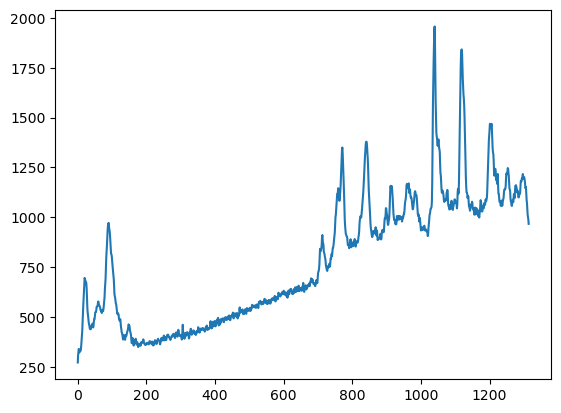

In [16]:
plt.plot(benzo_spec)

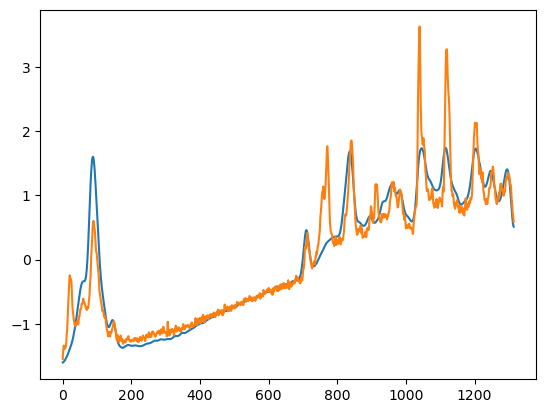

In [17]:
pmma_mean = np.mean(pmma_smoothed)
pmma_std = np.std(pmma_smoothed)
pmma_smoothed_normalized = (pmma_smoothed - pmma_mean)/pmma_std

benzo_mean = np.mean(benzo_spec)
benzo_std = np.std(benzo_spec)
benzo_spec_normalized = (benzo_spec - benzo_mean)/benzo_std

plt.plot(pmma_smoothed_normalized)
plt.plot(benzo_spec_normalized)

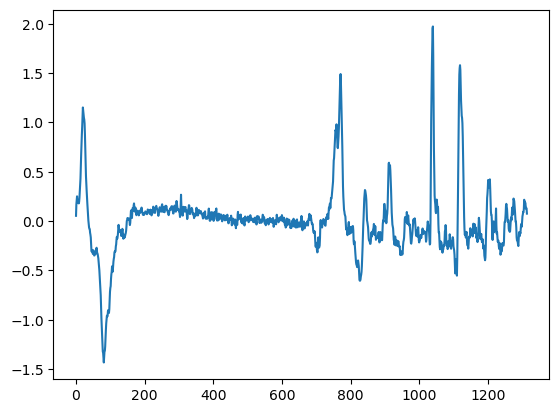

In [18]:
plt.plot(benzo_spec_normalized - pmma_smoothed_normalized)

# reference spectrum of benzoic acid

In [19]:
def readline(line: str) -> tuple[float, float]:
    x, y = line.split('  ')
    return (float(x), float(y))

In [20]:
with open('data/benzoic acid reference.txt') as f:
    benzo_ref = [ readline(l) for l in f.readlines() ]

In [21]:
wvns, vals = np.array(benzo_ref).transpose()
wvls = 2*np.pi/wvns

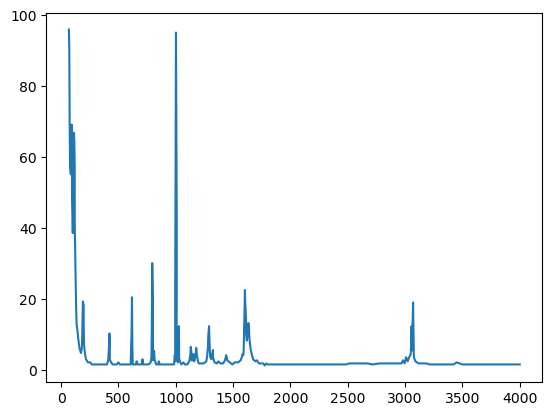

In [22]:
plt.plot(wvns, vals)

# trying to process in wavenumber space

[  88  145  710  836  895  958  981 1045 1115 1203 1247 1295]


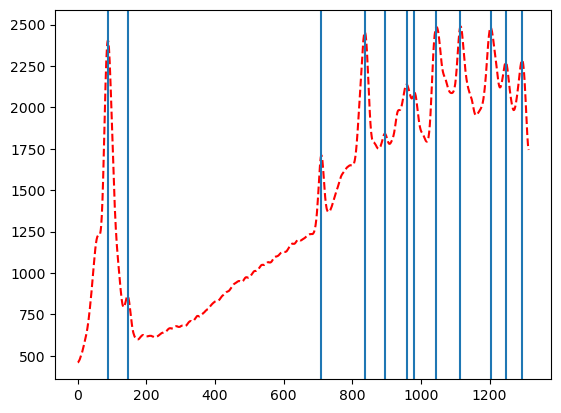

In [23]:
print(pmma_peaks)

plt.plot(pmma_smoothed, 'r--')
for x in pmma_peaks:
    plt.axvline(x)

[  22   91  148  713  769  840  914  963 1040 1120 1204 1252 1297]


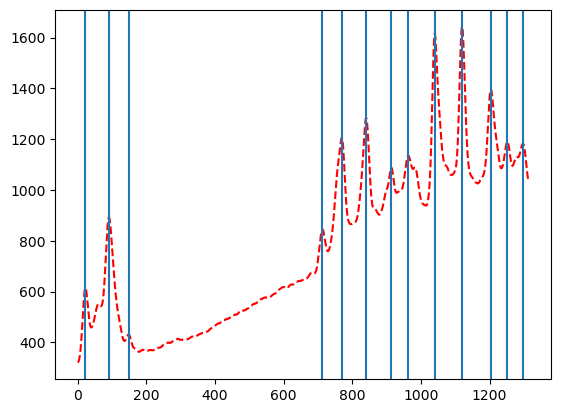

In [24]:
print(benzo_peaks)

plt.plot(benzo_smoothed, 'r--')
for x in benzo_peaks:
    plt.axvline(x)

In [25]:
ref_wvn  = [ 812.86, 976.28, 1451.9, 1728.9, 2844.9, 2952 ]
pmma_pn  = [ 1115, 1045, 836, 710, 145, 88 ]
benzo_pn = [ 1120, 1040, 840, 713, 148, 91 ]

pmma_fit  = np.poly1d(np.polyfit(pmma_pn, ref_wvn, 3))
benzo_fit = np.poly1d(np.polyfit(benzo_pn, ref_wvn, 3))

pmma_wvn  = pmma_fit(np.arange(0, len(pmma_spec)))
benzo_wvn = benzo_fit(np.arange(0, len(benzo_spec)))

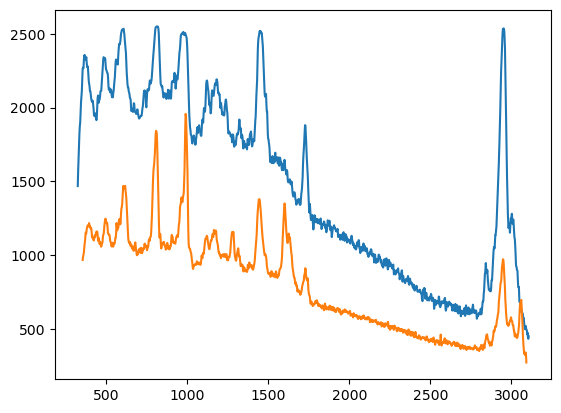

In [26]:
plt.plot(pmma_wvn, pmma_spec)
plt.plot(benzo_wvn, benzo_spec)

In [27]:
def gnorm(x):
    return (x - np.mean(x))/np.std(x)

In [28]:
pmma_mean = np.mean(pmma_spec)
pmma_std = np.std(pmma_spec)
pmma_spec_normalized = (pmma_spec - pmma_mean)/pmma_std

benzo_mean = np.mean(benzo_spec)
benzo_std = np.std(benzo_spec)
benzo_spec_normalized = (benzo_spec - benzo_mean)/benzo_std

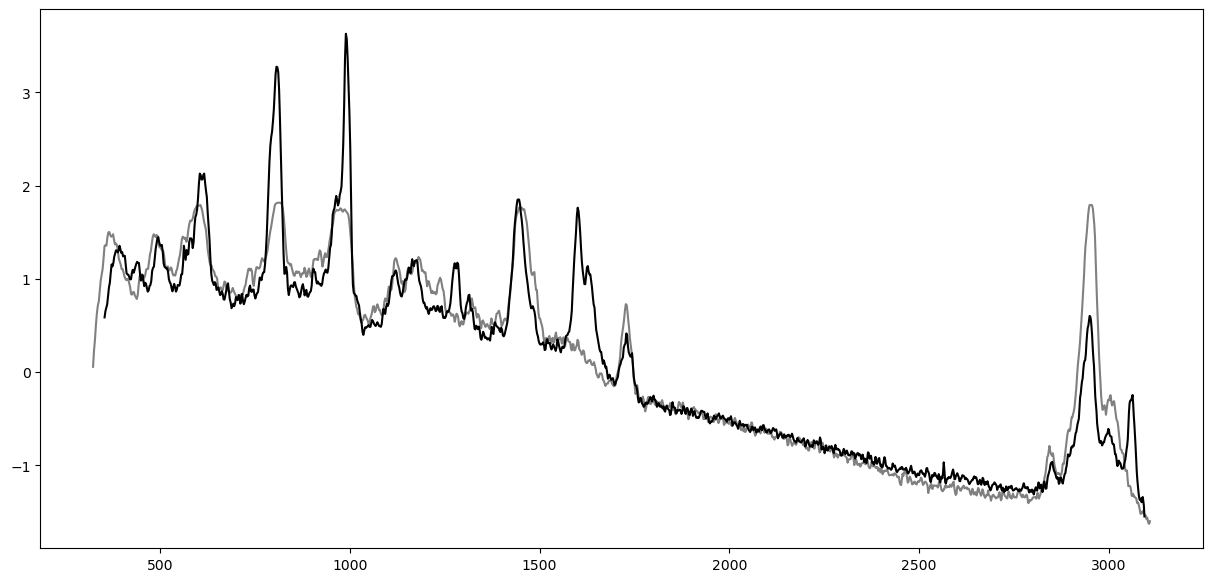

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(pmma_wvn, pmma_spec_normalized, c='gray')
plt.plot(benzo_wvn, benzo_spec_normalized, c='black')

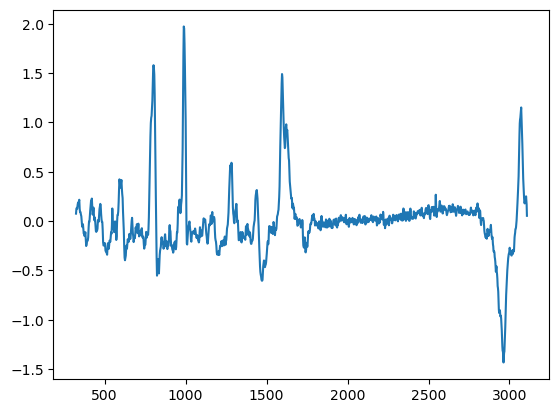

In [30]:
plt.plot(pmma_wvn, benzo_spec_normalized - pmma_smoothed_normalized)

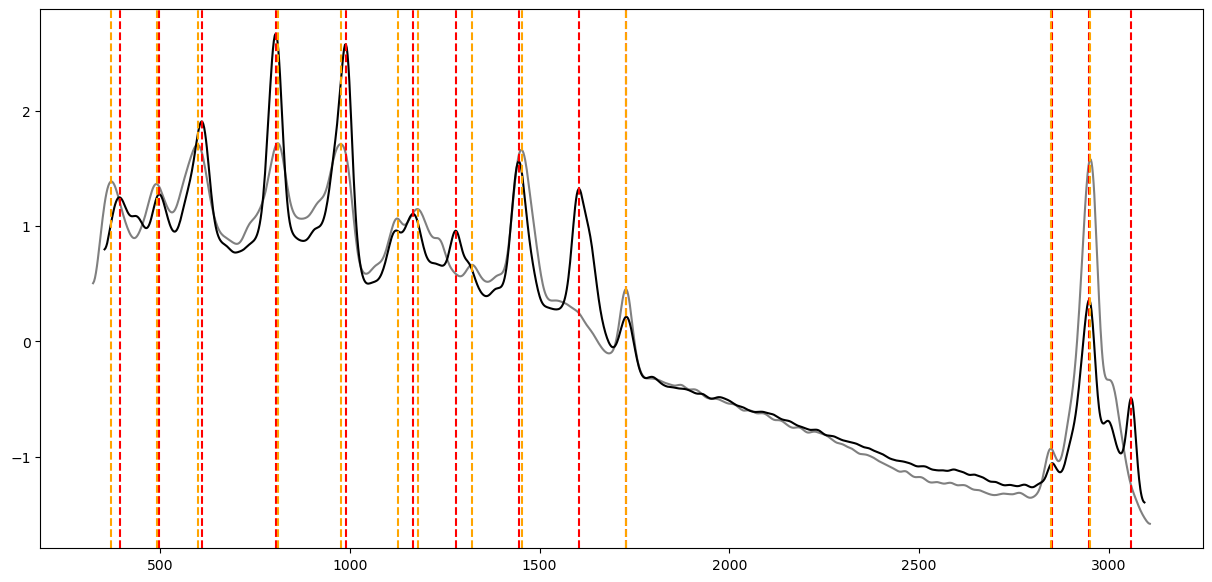

In [31]:
benzo_smoothed_normalized = gaussian_filter(benzo_spec_normalized, 5)
pmma_smoothed_normalized = gaussian_filter(pmma_spec_normalized, 5)

plt.figure(figsize=(15, 7))
plt.plot(pmma_wvn, pmma_smoothed_normalized, c='gray')
plt.plot(benzo_wvn, benzo_smoothed_normalized, c='black')

for x in benzo_peaks:
    plt.axvline(benzo_wvn[x], c='r', ls='--')

for x in pmma_peaks:
    plt.axvline(pmma_wvn[x], c='orange', ls='--')

In [56]:
def fit_func(x, poly_coeff, peak_amps, peak_widths, peak_means):
    ret = np.poly1d(poly_coeff)(x)
    for a, s, m in zip(peak_amps, peak_widths, peak_means):
        ret += a * np.exp(-(x-m)**2 / 2 / s**2)

    return ret


def fit_wrap(n_poly, peak_means):
    def f(x, *args):
        return fit(x, n_poly, peak_means, *args)

    return f


def params0(n_peaks, n_poly):
    return [0.1]*n_poly + [1]*(2*n_peaks)
    

def fit(x, n_poly, peak_means, *args):
    N = len(peak_means)
    M = n_poly
    return fit_func(x, args[:M], args[M:N+M], args[N+M:2*N+M], peak_means)


def bckg(x, n_poly, *args):
    return np.poly1d(args[:n_poly])(x)

# fit (x^7)

In [57]:
pmma_peak_wvns = [ pmma_wvn[x] for x in pmma_peaks ]
N_poly = 8
fit_fun_pmma = fit_wrap(N_poly, pmma_peak_wvns)

par_8, cov_8 = curve_fit(fit_fun_pmma, pmma_wvn, pmma_spec_normalized, p0=params0(len(pmma_peak_wvns), N_poly))

In [58]:
len(par_8), par_8

(32,
 array([-3.38857484e-22,  3.91053275e-18, -1.81110490e-14,  4.28132070e-11,
        -5.34992871e-08,  3.12741240e-05, -4.80016675e-03, -3.58150815e-01,
         2.64112323e+00,  3.80306434e-01,  8.11773324e-01,  1.47913163e+00,
         1.49329158e-01,  4.62794620e-01,  2.78304273e-01,  9.44512433e-01,
         8.43240607e-01,  9.85484981e-01,  8.21214014e-01,  1.34435613e+00,
         2.89710295e+01,  9.77452420e+00, -9.96800747e+00, -2.56384656e+01,
         4.70089164e+01,  3.79080141e+01,  7.00901175e+00,  2.12897470e+01,
         2.02665987e+01, -2.56254482e+01, -4.40269254e+01, -2.93246476e+01]))

In [59]:
cov_8

array([[ 4.27731240e-45, -5.21859592e-41,  2.59684093e-37, ...,
         1.30514559e-23,  4.92692722e-23, -5.06549994e-24],
       [-5.21859592e-41,  6.38755192e-37, -3.19036716e-33, ...,
        -1.64664042e-19, -6.33654684e-19,  9.40969835e-20],
       [ 2.59684093e-37, -3.19036716e-33,  1.60038647e-29, ...,
         8.45300002e-16,  3.35866597e-15, -6.91087260e-16],
       ...,
       [ 1.30514559e-23, -1.64664042e-19,  8.45300002e-16, ...,
         2.24111382e+00, -1.51633019e+00,  1.36816385e+00],
       [ 4.92692722e-23, -6.33654684e-19,  3.35866597e-15, ...,
        -1.51633019e+00,  8.68279091e+00, -3.46860107e+00],
       [-5.06549994e-24,  9.40969835e-20, -6.91087260e-16, ...,
         1.36816385e+00, -3.46860107e+00,  5.28023805e+00]])

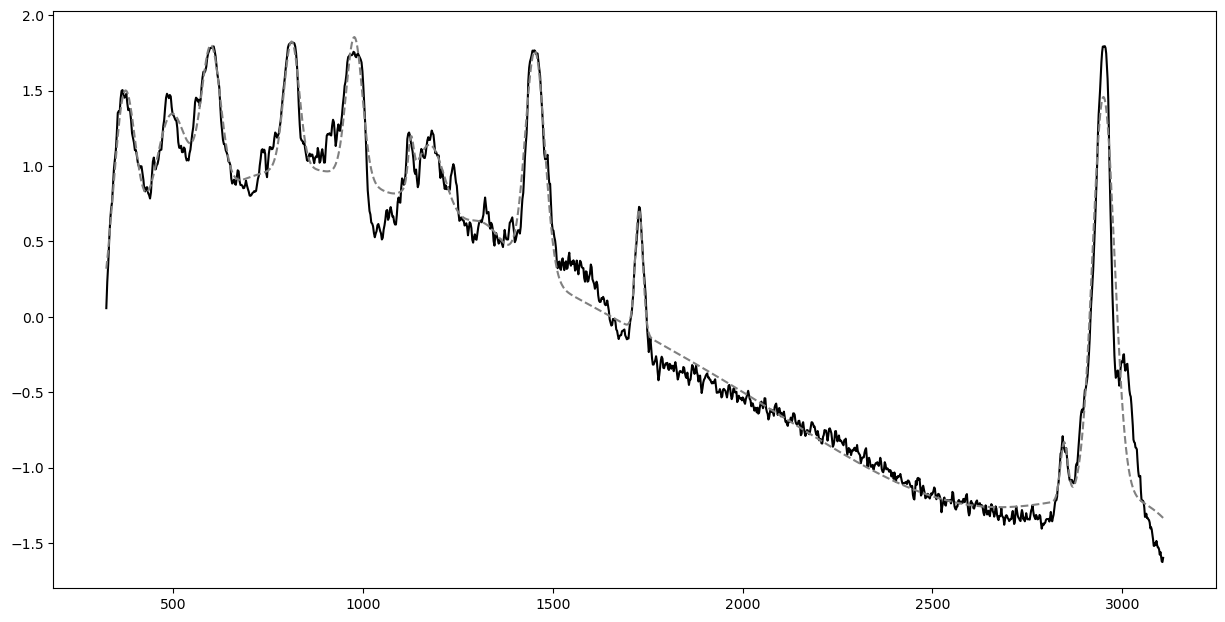

In [60]:
plt.figure(figsize=(15, 7.5))
plt.plot(pmma_wvn, pmma_spec_normalized, c='black')
plt.plot(pmma_wvn, fit_fun_pmma(pmma_wvn, *par_8), c='gray', ls='--')

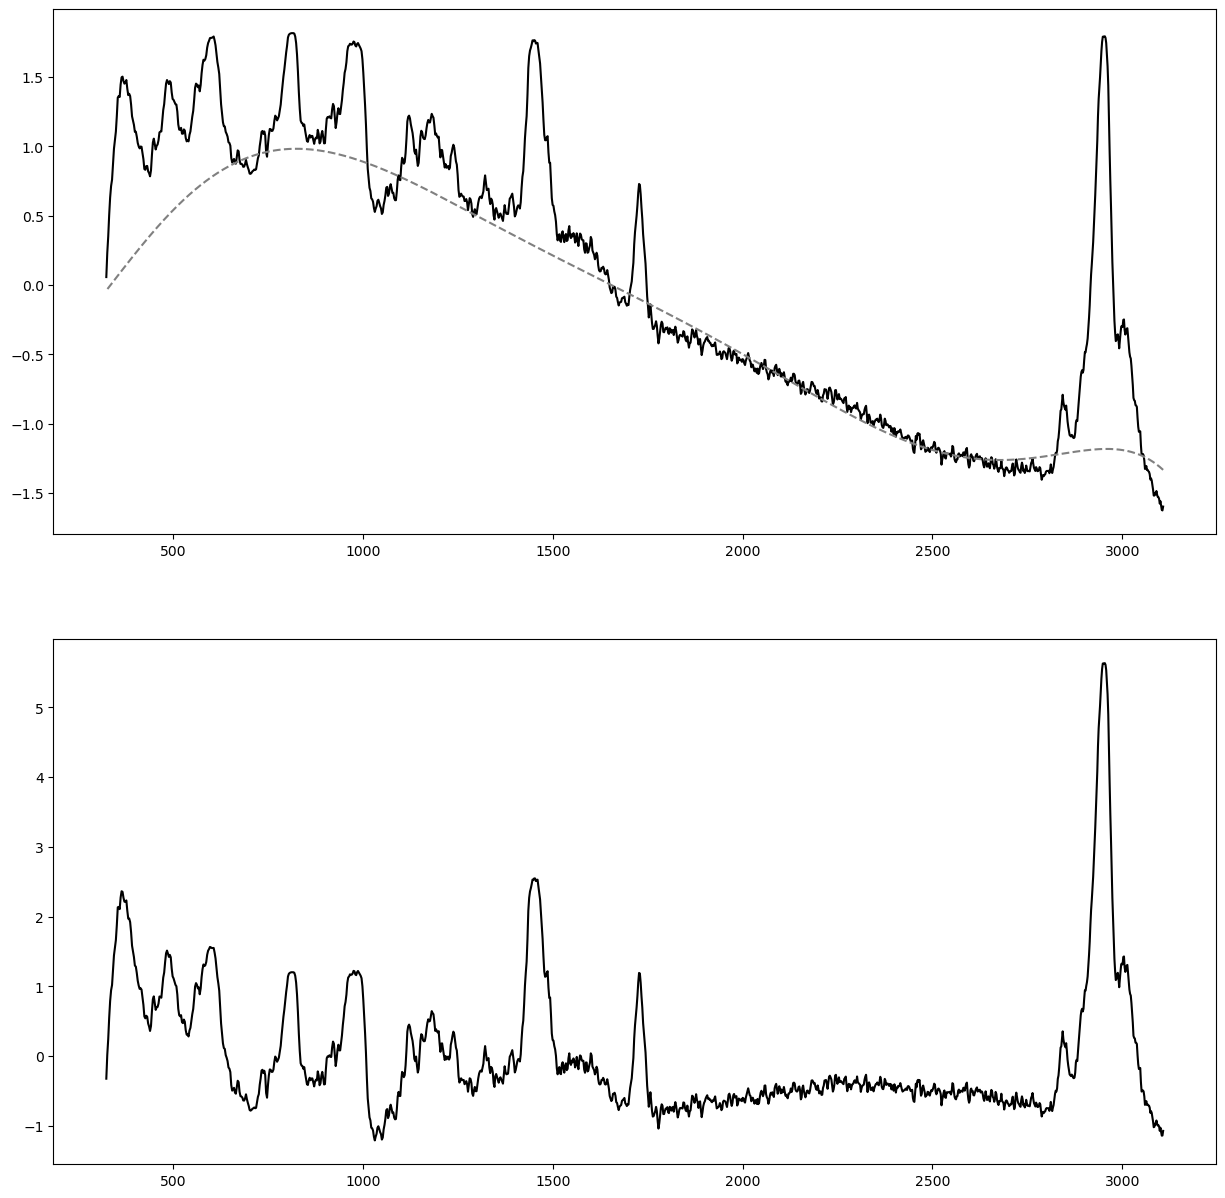

In [61]:
signal_8 = gnorm(pmma_spec_normalized - bckg(pmma_wvn, N_poly, *par_8))

fig, ax = plt.subplots(2, figsize=(15, 15))
ax[0].plot(pmma_wvn, pmma_spec_normalized, c='black')
ax[0].plot(pmma_wvn, bckg(pmma_wvn, N_poly, *par_8), c='gray', ls='--')
ax[1].plot(pmma_wvn, signal_8, c='black')

# fit (x^3)

In [62]:
pmma_peak_wvns = [ pmma_wvn[x] for x in pmma_peaks ]
N_poly = 4
fit_fun_pmma = fit_wrap(N_poly, pmma_peak_wvns)

par_4, cov_4 = curve_fit(fit_fun_pmma, pmma_wvn, pmma_spec_normalized, p0=params0(len(pmma_peak_wvns), N_poly))

In [63]:
len(par_4), par_4

(28,
 array([ 5.12398504e-10, -2.78583286e-06,  3.41829457e-03, -3.08497050e-01,
         2.70095307e+00,  4.58447306e-01,  7.90166677e-01,  1.43149755e+00,
         2.05654848e-01,  4.41381655e-01,  2.76332898e-01,  9.96923046e-01,
         8.58340650e-01,  9.34511095e-01,  5.65540109e-01,  9.19212271e-01,
         3.16212723e+01,  1.36575726e+01,  9.61362046e+00,  2.42335474e+01,
         1.02102305e+01,  3.96328953e+01, -7.04006393e+00,  2.28254867e+01,
        -2.52466775e+01, -2.58981620e+01, -3.88787866e+01, -2.08090771e+01]))

In [64]:
cov_4

array([[ 2.66827137e-22, -1.49963818e-18,  2.55205006e-15,
        -1.24391246e-12, -5.84084735e-14, -1.96962377e-14,
        -4.60657630e-14, -8.29598121e-14, -8.86640190e-14,
        -8.65713518e-14,  4.74263096e-14, -4.87311459e-14,
         1.13592819e-14,  1.50685537e-13,  3.34810733e-13,
         3.93956936e-13, -1.45870979e-12,  9.27185804e-15,
        -1.11904032e-12, -2.76731886e-12, -8.15677814e-12,
        -1.59884156e-11, -1.39190622e-12, -2.07371137e-12,
        -8.41782834e-13, -2.97240477e-12, -9.88470283e-12,
        -1.15328227e-11],
       [-1.49963818e-18,  8.55184298e-15, -1.48135941e-11,
         7.39186122e-09,  2.61536417e-10,  6.36185414e-11,
         2.89580106e-10,  4.81997843e-10,  5.02090419e-10,
         4.74045651e-10, -2.69740387e-10,  2.32103817e-10,
        -1.34660102e-10, -9.71941781e-10, -2.09198424e-09,
        -2.40973477e-09,  6.87191120e-09, -1.71408462e-09,
         7.03429934e-09,  1.60736133e-08,  4.62885694e-08,
         8.78168281e-08,  8.11

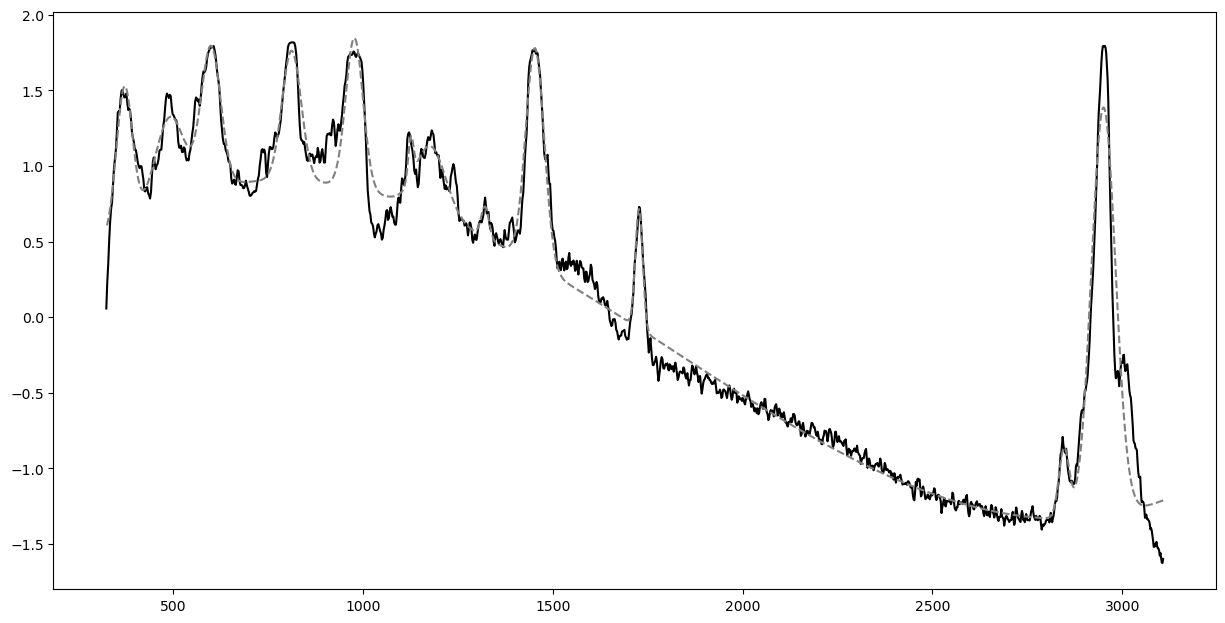

In [65]:
plt.figure(figsize=(15, 7.5))
plt.plot(pmma_wvn, pmma_spec_normalized, c='black')
plt.plot(pmma_wvn, fit_fun_pmma(pmma_wvn, *par_4), c='gray', ls='--')

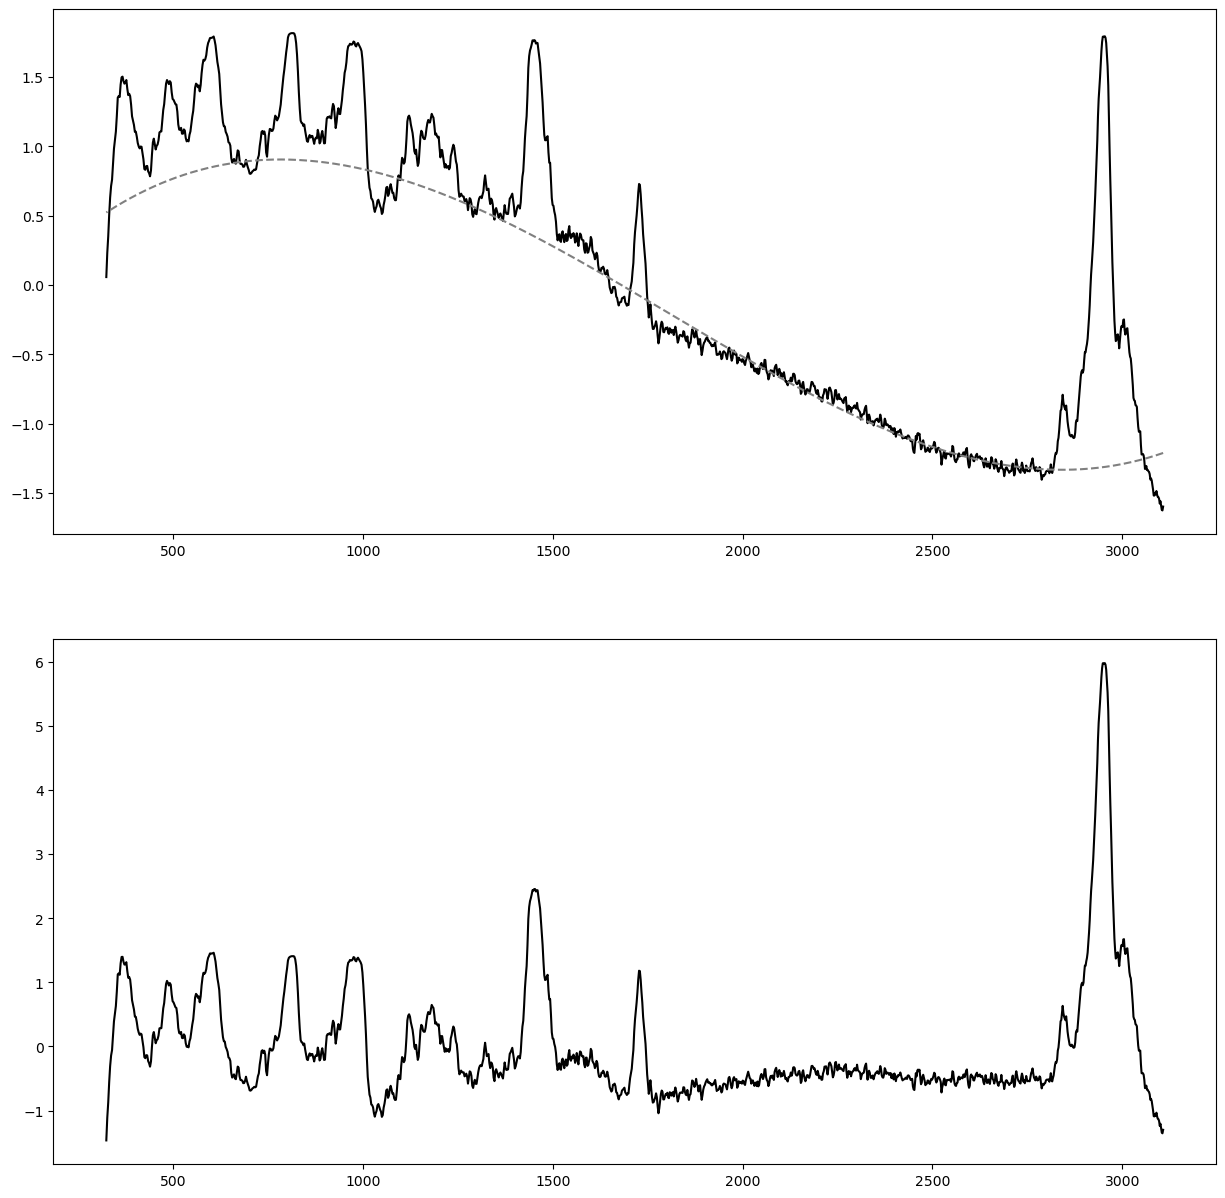

In [66]:
signal_4 = gnorm(pmma_spec_normalized - bckg(pmma_wvn, N_poly, *par_4))

fig, ax = plt.subplots(2, figsize=(15, 15))
ax[0].plot(pmma_wvn, pmma_spec_normalized, c='black')
ax[0].plot(pmma_wvn, bckg(pmma_wvn, N_poly, *par_4), c='gray', ls='--')
ax[1].plot(pmma_wvn, signal_4, c='black')

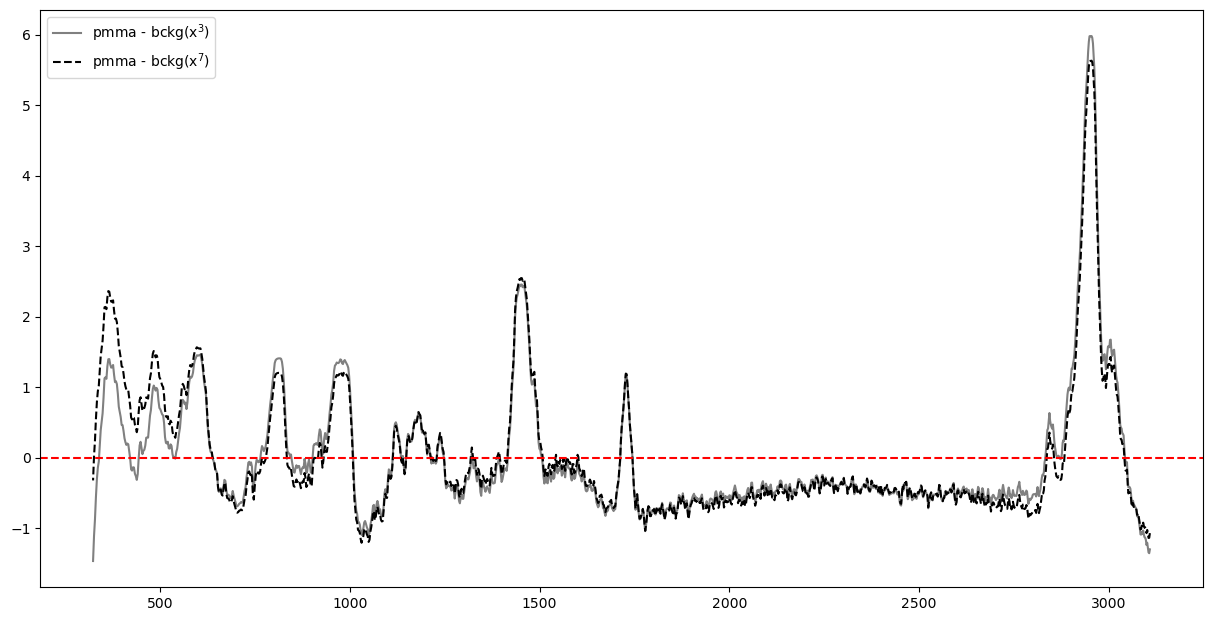

In [163]:
plt.figure(figsize=(15, 7.5))
plt.plot(pmma_wvn, signal_4, c='gray', label='pmma - bckg(x$^3$)')
plt.plot(pmma_wvn, signal_8, c='black', ls='--', label='pmma - bckg(x$^7$)')
plt.axhline(0, c='red', ls='--')
plt.legend()

# fit (gaussian)

In [153]:
def fit_func(x, bckg_args, peak_amps, peak_widths, peak_means):
    C, A, M, S = bckg_args
    ret = C + A * np.exp(-(x-M)**2 / 2 / S**2)
    for a, s, m in zip(peak_amps, peak_widths, peak_means):
        ret += a * np.exp(-(x-m)**2 / 2 / s**2)

    return ret


def fit_wrap(peak_means):
    def f(x, *args):
        return fit(x, peak_means, *args)

    return f


def params0(n_peaks):
    return [-1, 2, 0, 3000] +[1]*(2*n_peaks)
    

def fit(x, peak_means, *args):
    N = len(peak_means)
    return fit_func(x, args[:4], args[4:N+4], args[N+4:2*N+4], peak_means)


def bckg(x, *args):
    c, a, m, s = args[:4]
    return c + a * np.exp(-(x-m)**2 / 2 / s**2)

In [154]:
pmma_peak_wvns = [ pmma_wvn[x] for x in pmma_peaks ]
fit_fun_pmma = fit_wrap(pmma_peak_wvns)

par_g, cov_g = curve_fit(fit_fun_pmma, pmma_wvn, pmma_spec_normalized, p0=params0(len(pmma_peak_wvns)))

In [155]:
len(par_g), par_g

(28,
 array([-1.43109261e+00,  2.35640297e+00,  8.64450931e+02,  8.07634750e+02,
         2.69372827e+00,  4.53597007e-01,  8.10750126e-01,  1.41519127e+00,
         1.66667620e-01,  3.86039659e-01,  2.83206906e-01,  9.52364361e-01,
         8.59473605e-01,  9.67328808e-01,  6.29967001e-01,  9.86923070e-01,
         3.30074570e+01,  1.18012073e+01,  9.94825664e+00,  2.34968320e+01,
         7.29662567e+00,  3.34045964e+01,  7.02720445e+00,  2.14780695e+01,
         2.39269597e+01,  2.63017109e+01,  4.27355718e+01,  2.19371390e+01]))

In [156]:
cov_g

array([[ 3.55891018e-04, -3.18470938e-04,  1.41652680e-01,
        -2.43495073e-01, -1.65441628e-04, -1.26719743e-04,
         2.32480377e-05, -3.79510791e-05, -6.37125392e-05,
        -7.70395227e-05,  2.71837093e-05, -6.03096102e-05,
        -6.70700913e-06,  1.07932966e-04,  2.57337530e-04,
         2.73133157e-04, -3.28578624e-03, -4.64548973e-03,
         5.65975343e-04, -1.23599675e-03, -5.50104096e-03,
        -1.40517458e-02,  4.07112397e-04, -2.61097095e-03,
        -2.43703231e-04,  2.35828004e-03,  4.20688549e-03,
         7.38130750e-03],
       [-3.18470938e-04,  4.90339781e-04, -2.02915879e-01,
         2.32212620e-01,  1.50660685e-04,  1.16463009e-04,
        -2.70366242e-05, -1.42713069e-06,  9.65947232e-07,
        -1.24343036e-05, -8.23843478e-06, -6.88333046e-05,
        -1.49480610e-04, -2.99317419e-04, -5.40629164e-04,
        -4.84041879e-04,  2.98555849e-03,  4.28970924e-03,
        -6.61446889e-04, -8.39084913e-05,  7.77157357e-05,
        -1.89331854e-03, -5.43

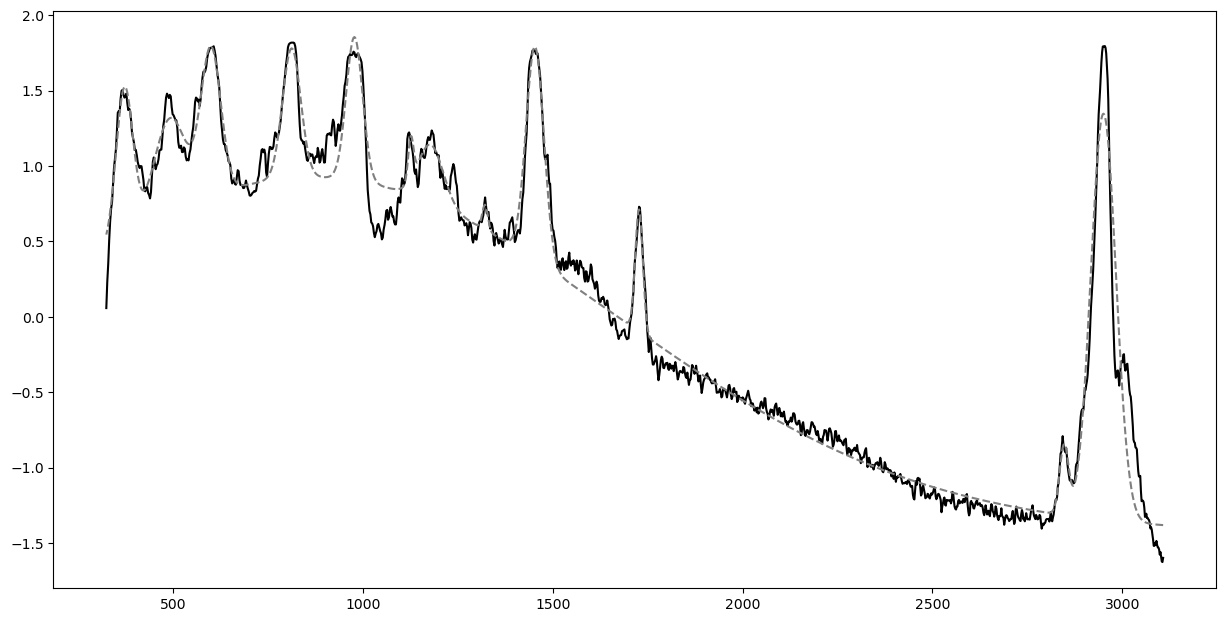

In [157]:
plt.figure(figsize=(15, 7.5))
plt.plot(pmma_wvn, pmma_spec_normalized, c='black')
plt.plot(pmma_wvn, fit_fun_pmma(pmma_wvn, *par_g), c='gray', ls='--')

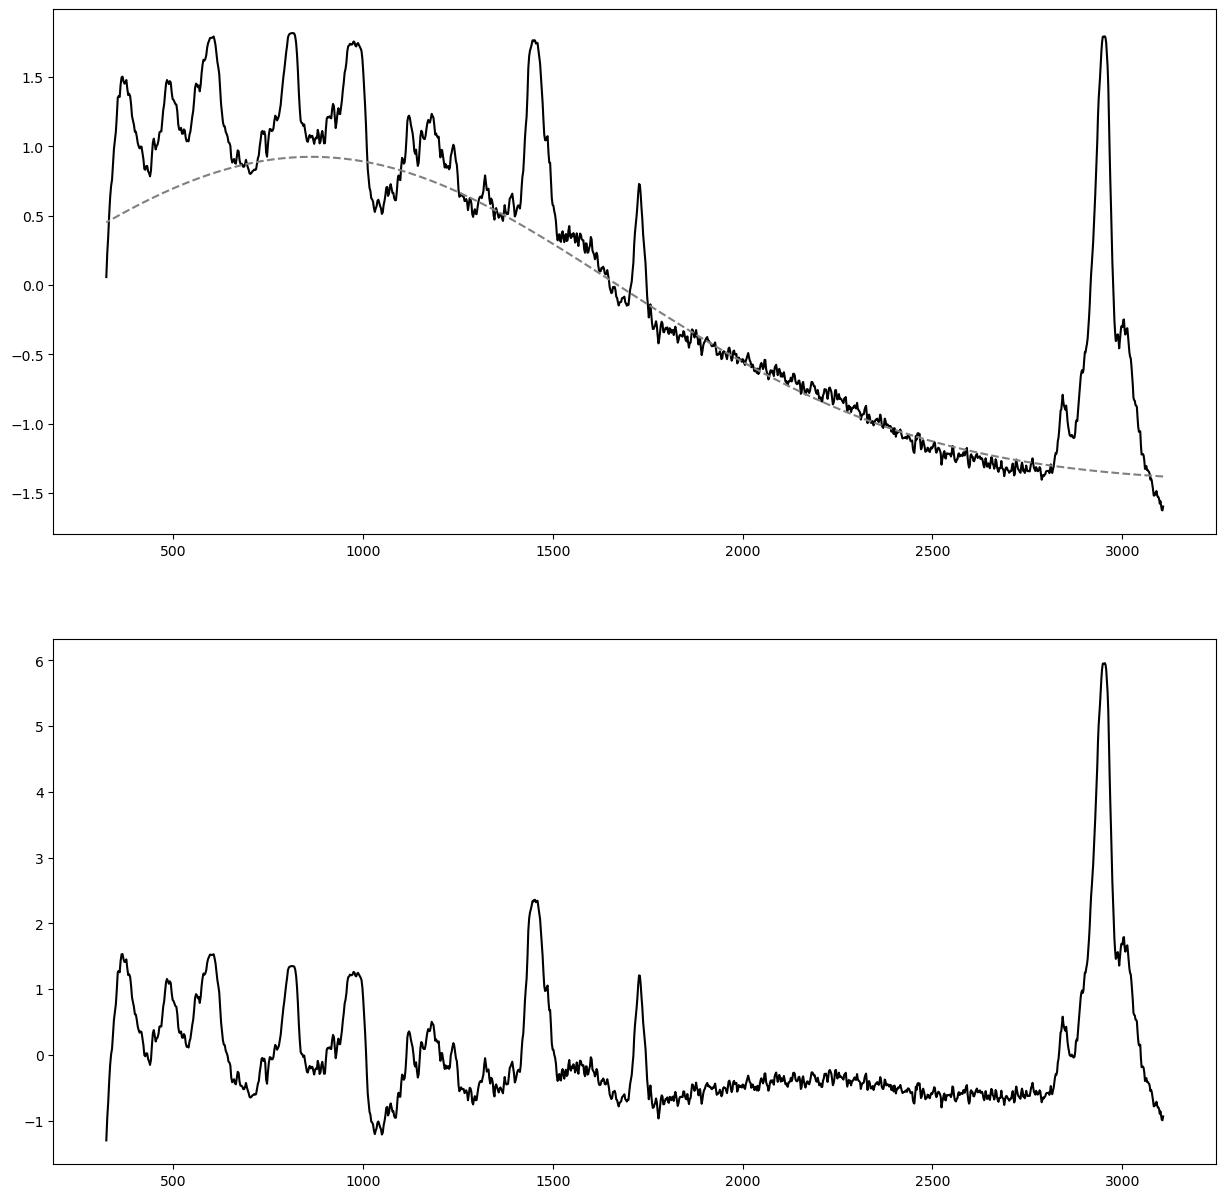

In [158]:
signal_g = gnorm(pmma_spec_normalized - bckg(pmma_wvn, *par_g))

fig, ax = plt.subplots(2, figsize=(15, 15))
ax[0].plot(pmma_wvn, pmma_spec_normalized, c='black')
ax[0].plot(pmma_wvn, bckg(pmma_wvn, *par_g), c='gray', ls='--')
ax[1].plot(pmma_wvn, signal_g, c='black')

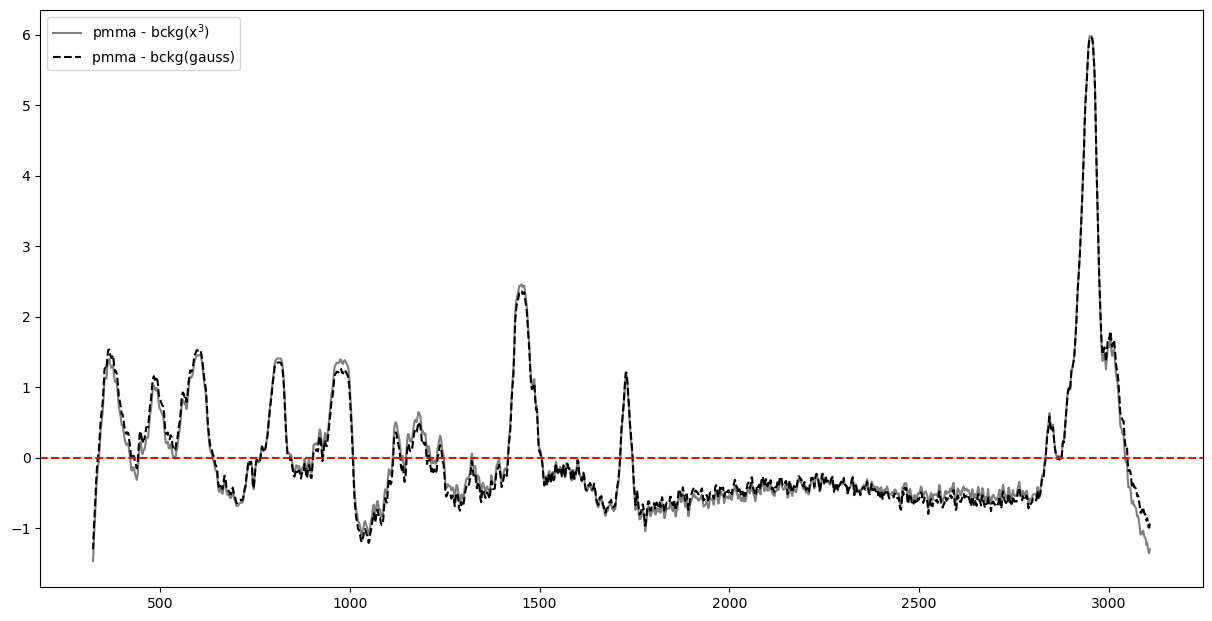

In [162]:
plt.figure(figsize=(15, 7.5))
plt.plot(pmma_wvn, signal_4, c='gray', label='pmma - bckg(x$^3$)')
plt.plot(pmma_wvn, signal_g, c='black', ls='--', label='pmma - bckg(gauss)')
plt.axhline(0, c='red', ls='--')
plt.legend()